# Plan-and-Execute
ユーザーからの質問に対して実行計画を作成し、その計画に従ってタスクを実行する例

- 題材
  - Plan-and-Execute(https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/)

![plan-and-execute](./img/plan-and-execute.png)

## セットアップ

In [1]:
%%capture --no-stderr
%pip install --qU langgraph langchain-community langchain-openai tavily-python python-dotenv

## 環境変数

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## モデルの定義

In [3]:
from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # これだと推論終わらない
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
# llm = ChatOpenAI(model="gpt-4-turbo-preview", temperature=0)  # Tutorialではこれ使ってるけど料金高いのでやめた

## Stateの定義(Status)
GraphのNode間でデータ共有を行うための`Status`を定義する。
- `input`: ユーザーからの入力
- `response`: 最終的な回答
に加え、
- `plan`：現在の実行計画(`Step`のリストで定義)
- `past_steps`：これまでの実行した`Step`とその結果の`tuple`のリストとして定義 
  - `Annotation`で`add`を指定することでリストの要素が追加されるようにする(デフォルトは`set`)
をフィールドに持たせる。

`State`は`TypedDict`または`Pydantic`の`BaseModel`を継承したクラスで定義する。

- State(https://langchain-ai.github.io/langgraph/concepts/low_level/#state)
- Define state(https://langchain-ai.github.io/langgraph/how-tos/state-reducers/#define-state)


In [4]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class Status(TypedDict):
    input: str
    plan: List[str]  # PlanをStepのリストとして定義
    past_steps: Annotated[List[Tuple], operator.add]  # 実行したstepとその結果の組み合わせをtupleとしてListに追加していく
    response: str

## Planning Stepの定義
ユーザーからの質問に対して、LLMに`Plan`を作成させるための`Chain`を定義する。  

### Planクラスの定義
LLMが作成した実行計画を格納するための`Plan`クラスを定義する。

In [5]:
from pydantic import BaseModel, Field

class Plan(BaseModel):
    """タスクの実行計画"""

    steps: List[str] = Field(description="実行すべきタスクを実行する順番に並べる")

### Plannerの定義
ユーザーからの質問に対して実行計画(`Plan`)を作成する`Chain`を定義する。  
`with_structured_output()`により、LLMには`Plan`クラスのインスタンスとして回答を返させる。

### (補足)ChatPromptTemplate

- `ChatPromptTemplate.from_messages()`(https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html#langchain_core.prompts.chat.ChatPromptTemplate.from_messages)
- `ChatPromptTemplate`(https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html#langchain_core.prompts.chat.ChatPromptTemplate)
  - `Placeholder`を含める場合はvalueはtupleのリスト(=`ChatPromptTemplate`型)である必要がある

In [6]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
        "system",
            """与えられた目標を達成するためのステップバイステップの実行計画を作成してください。 \
この計画は個々のタスクから成り、正しく実行されると正しい回答を得られます。余分なステップを追加しないでください。 \
最終ステップの結果は最終的な回答になります。各ステップには必要なすべての情報が含まれていることを確認してください。ステップをスキップしないでください。""",
        ),
        ("placeholder", "{messages}"),  # placeholderを指定した場合、messagesはtupleのリスト(=ChatPromptTemplate型)である必要がある
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)  # Planを作成するChainを定義

### (動作検証)Planner Chainの実行
`LLM`に`Plan`を作成させる。


In [7]:
planner.invoke({"messages": [("user", "現在の全豪オープン優勝者の出身地はどこですか？")]})

Plan(steps=['現在の全豪オープンの最新の優勝者を特定する。', 'その優勝者の出身地を調べる。', '調べた出身地を回答として提示する。'])

### Planner Chainを実行する関数を定義
`planner`を実行して質問に対する`Plan`を作成する。

In [8]:
async def planning_node(state: Status):
    planner_response = await planner.ainvoke({"messages": [("user", state["input"])]})  # Chainの引数にはStatusのinputを渡す
    return {"plan": planner_response.steps}  # Planの作成結果をStatusの差分(plan)として返却

## ReAct Agentの定義
与えられた質問に関する調査を行うReAct Agentを定義する。

### ツールの定義
### Web検索ツール(tavily_tool)
`Tavily`でWeb検索を行うツールを作成する。

`LangChain`では`BaseTool`を継承した`tools`のライブラリ(`langchain_community.tools`)が提供されており、ここではその中から`Tavily`でWeb検索を行う`TavilySearchResults`を使用する。

- `langchain_community.tools`(https://python.langchain.com/api_reference/community/tools.html)
- `BaseTool`(https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.BaseTool.html#langchain_core.tools.base.BaseTool)
- `TavilySearchResults`(https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=10)]

### Agentの作成
タスクを実行するAgentとして`ReAct Agent`を定義する。

`create_react_agent()`を使用してグラフを作成することで、`ReAct`に沿ったグラフを作成できる。  

- `create_react_agent()`( https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent )

In [10]:
from langgraph.prebuilt import create_react_agent

prompt = "You are a helpful assistant."
react_agent = create_react_agent(llm, tools, prompt=prompt)

# なくても良い
# from langchain.agents import AgentExecutor
# react_agent_executor = AgentExecutor(agent=react_agent, tools=tools, verbose=True)

### Agentを実行する関数の定義
`PlanExecute`から`plan`を取得し、1つ目のステップを実行する。

In [11]:
async def agent_node(state: Status):
    plan = state["plan"]  # 現在のPlanを取得
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))  # Planを箇条書きの文字列に変換
    tasked_step = plan[0]  # 現在のPlanの最初のStepを取得

    # 現在のPlanに対し、最初のStepの実行を指示するプロンプトを作成
    agent_prompt = f"""タスクの実行計画:\n\n{plan_str}\n\n実行計画の1つ目のステップを実行してください。ステップとして定義された以外のことは行わないでください。\n\nStep {1}, {tasked_step}"""  
    
    agent_response = await react_agent.ainvoke({"messages": [("user", agent_prompt)]})

    return {  # Agentの回答をStatusの差分(past_steps)として返却(実行したStepとその結果のtuple)
        "past_steps": [(tasked_step, agent_response["messages"][-1].content)],
    }

## Re-Planning Stepの定義
現在の`Plan`の最初の`Step`を実行した結果(`Status.past_steps`)を踏まえて回答(`Status.response`)の作成または実行計画(`Status.plan`)の再作成を行う。

### Responseクラスの定義
LLMからの回答を格納するための`Response`クラスを定義する。
実際にLLMからの回答はこの後定義する`Act`クラスで受け取っており、`Response`クラスはその中でユーザーへの回答を格納するための型として使用されている。

In [12]:
class Response(BaseModel):
    """ユーザーへの回答"""

    response: str = Field(description="ユーザーへの回答")

### Actクラスの定義
LLMの回答を格納するための`Act`クラス(ユーザーに回答(`Response`)を返すか、新たに実行計画(`Plan`)を作成するかを決定する)を定義する。  
`Union`を用いることで、`Act.action`には`Response`クラスと`Plan`クラスのいずれかを含められるようにしている。  
(この結果に応じて`Graph`の`Edge`で分岐処理を行う)

- `Response`クラス：ユーザーに対する回答
- `Plan`クラス：新たに作成した計画

In [13]:
from typing import Union

class Act(BaseModel):
    """実行するアクション"""

    action: Union[Response, Plan] = Field(
        description="実行するアクション。目標に対する最終的な結論が得られた場合はその内容をResponseに登録してください。"
        "結論を得るためにさらにステップを実行する場合は、Planに再計画した実行計画を登録して下さい。"
    )

### Re-Planner Chainの定義

In [14]:
replanner_prompt = ChatPromptTemplate.from_template(
    """与えられた目標を達成するためのステップバイステップの計画を作成してください。 \
この計画は個々のタスクから成り、正しく実行されると正しい回答を得られます。余分なステップを追加しないでください。 \
最終ステップの結果は最終的な回答になります。各ステップには必要なすべての情報が含まれていることを確認してください。ステップをスキップしないでください。

与えられた目標:
{input}

目標達成に向けた実行計画:
{plan}

現在までに実行したステップとその結果:
{past_steps}

更新した計画を作成してください。もしもさらにステップを実行する必要がない場合は、その結果を返してください。それ以外の場合は実行計画を更新してください。
必要なステップのみを実行計画に追加してください。前に実行したステップを計画に含めないでください。"""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

### Re-Planner Chainを実行する関数の定義
`Chain`実行時の引数として`Status`クラスのインスタンスを渡すことで、プロンプト(`replanner_prompt`)の各Placeholderに`Status`クラスのインスタンスの各フィールドの値が展開される。  
`Replanner Chain`を実行してレスポンスの型が`Response`クラスの場合は回答を返し、`Plan`クラスの場合は見直し後の`Plan.steps`を返す。  
`isinstance()`によってインスタンスのクラスを判定する。

In [15]:
async def replanning_node(state: Status):  # replannerを実行して回答、または見直し後のPlanを返す
    replanner_response = await replanner.ainvoke(state)
    
    if isinstance(replanner_response.action, Response):
        return {"response": replanner_response.action.response}
    else:
        return {"plan": replanner_response.action.steps}

## Graphの定義

### Graphの初期化

In [16]:
from langgraph.graph import StateGraph
workflow = StateGraph(Status)

### Nodeの追加

In [17]:
from langgraph.graph import START

workflow.add_node("planning_node", planning_node)
workflow.add_node("agent_node", agent_node)
workflow.add_node("replanning_node", replanning_node)

### Stateの値に応じて分岐を行うための関数を定義

In [18]:
from langgraph.graph import END

def should_end(state: Status):
    if "response" in state and state["response"]:  # Statusにresponseが含まれている場合は終了
        return END
    else:  # Statusにresponseが含まれていない場合はagent Nodeに戻る(見直し後のPlanに基づいて実行される)
        return "agent_node"

### Edgeの追加

In [19]:
workflow.add_edge(START, "planning_node")
workflow.add_edge("planning_node", "agent_node")
workflow.add_edge("agent_node", "replanning_node")

workflow.add_conditional_edges(  # 分岐処理を行うEdgeを追加
    "replanning_node",  # 始点: replanning_step Node
    should_end,  # should_endの戻り値に応じて次のNodeを決定
    ["agent_node", END],  # 遷移先: agent NodeまたはEND
)

### Graphのコンパイル

In [20]:
graph = workflow.compile()

## Graphの実行

In [21]:
config = {"recursion_limit": 20}
inputs = {"input": "自動車メーカーホンダの創業者の出身地の名物料理はなんですか?"}
# inputs = {"input": "円周率 > 3.05を証明してください。"}
# inputs = {"input": "富士山はどの県のものですか?必ず1つに絞って回答してください。"}
async for event in graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['ホンダの創業者の名前を確認する。', 'ホンダの創業者の出身地を調べる。', 'その出身地の名物料理を調べる。', '名物料理の名前を回答として提示する。']}
{'past_steps': [('ホンダの創業者の名前を確認する。', 'ホンダの創業者の名前は「本田宗一郎」です。')]}
{'plan': ['ホンダの創業者の出身地を調べる。', 'その出身地の名物料理を調べる。', '名物料理の名前を回答として提示する。']}
{'past_steps': [('ホンダの創業者の出身地を調べる。', 'ホンダの創業者である本田宗一郎の出身地は、静岡県磐田郡光明村（現：浜松市天竜区）です。')]}
{'plan': ['その出身地の名物料理を調べる。', '名物料理の名前を回答として提示する。']}
{'past_steps': [('その出身地の名物料理を調べる。', '出身地の名物料理について調べました。具体的な出身地を教えていただければ、その地域の名物料理をさらに詳しく調べることができます。')]}
{'plan': ['本田宗一郎の出身地である浜松市天竜区の名物料理を具体的に調べる。', '調べた名物料理の名前を回答として提示する。']}
{'past_steps': [('本田宗一郎の出身地である浜松市天竜区の名物料理を具体的に調べる。', '浜松市天竜区の名物料理としては、特に「浜松餃子」が有名です。また、地元の川魚を使った料理や、そば、カレーなども地域の特色ある料理として挙げられています。具体的な名物料理としては以下のようなものがあります。\n\n- 浜松餃子\n- にじます定食（刺身、塩焼きなど）\n- 天浜線転車台カレー（三ケ日牛カレー）\n- 手打ちそば\n- 緑茶入り生クリームどら焼き（春野名物）\n\nこれらが浜松市天竜区の名物料理の一例です。次のステップでこれらの中から回答として提示します。')]}
{'response': 'ホンダの創業者本田宗一郎の出身地である浜松市天竜区の名物料理として、特に有名なのは「浜松餃子」です。その他にも、にじます定食、天浜線転車台カレー（三ケ日牛カレー）、手打ちそば、緑茶入り生クリームどら焼き（春野名物）などがありますが、代表的な名物料理は「浜松餃子」です。'}


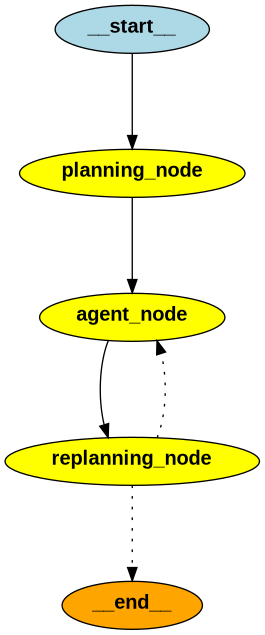

In [22]:
from IPython.display import Image

Image(graph.get_graph().draw_png())